#Comparison of Portfolio Generation Schemes  

In this notebook, the docplex library is used to implement risk-parity, robust, and basic Mean Variance Optimization methods. The monthly adjusted close returns for 20 stocks from January 2008 to November 2011 are used to generate portfolio weights with a six month rolling horizon and the sharp ratio and equity curves for all strategies evaluted.

In [ ]:
# """
# Optimizer libraries
!pip install cplex
!pip install docplex
# """

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 9.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671350 sha256=a106dcba03a4cda71931f38aeb4da378bf12e9644a7b3f0fdbbc6495560aaf55
  Stored in directory: /root/.cache/pip/wheels/3b/e5/00/0bf0173d67188fe73a13e3a61412b3f975f60205e3fab93a69
Successfully built docplex


In [ ]:
import numpy as np
import pandas as pd
import cplex as cp
from docplex.mp.model import Model
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [ ]:
###SHARES OUTSTANDING###

# Hard coding shares outstanding for market cap estimations
# In alphabetical order to match other datasets
shares = [15787154000, 1943500000, 517400000, 1825000000, 352900000, 3990000000\
          ,907500000, 2634300000, 2968500000, 4326000000, 730031742, 622000000 \
          ,794000000, 1378000000, 5634000000, 7168000000, 4207000000 \
          ,3785600000, 2696000000, 4102000000]

In [ ]:
### RISK FREE RATE###

# Choose an estimate of the risk free return
# https://www.marketwatch.com/investing/bond/tmubmusd01m/download-data?startDate=12/29/2007&endDate=12/29/2011&countryCode=bx
# Average US 1 month treasury bill return over the period in question was 0.374%
# r_f = 0.00374 (monthly)
# below the 1% average (min around 0.7%) in the 2010 to 2011 period

risk_free_rate = 0.00374


In [ ]:
###RAW DATA### - Adjustd Closing Excel File from Yahoo Finance.

"""
stocks = [F,CAT,DIS,MCD,KO, PEP,WMT,C, WFC, JPM ,AAPL, IBM, PFE, \
          JNJ, XOM, MRO,ED, T, VZ, NEM]
"""


# retrieve monthly adjusted data
adj_close_dated = pd.read_excel("Adj_closing_summarized.xlsx")
adj_close = adj_close_dated.drop("Date", axis = 1)

adj_returns =(adj_close.shift(-1) - adj_close)/adj_close
adj_returns.drop(adj_returns.index[-1], inplace = True)

# Keeping Dated returns with the same index so it's easy to know which dates
# go with which index
adj_returns_dated = adj_close_dated.loc[1:, "Date"]
adj_returns_dated.reset_index(drop = True, inplace = True)
adj_returns_dated = pd.concat((adj_returns_dated,adj_returns), axis = 1 )

## MVO Functions

In [ ]:
def RAR_MVO(adjusted_close, risk_lambda = 0.1):
  """
  Performs the risk-adjusted return mean variance optimization

  adjusted_closes - dataframe of adjusted close prices
  risk_lambda - the risk aversion parameter lambda in the RAR MVO formulation
  """
  # setup

  # Generate Parameters / returns
  adj_returns = (adjusted_close.shift(-1) - adjusted_close)/adjusted_close
  adj_returns.drop(adj_returns.index[-1], inplace = True)

  expected_returns = list(adj_returns.mean()) #Compute mean historical returns
  cov_mat = adj_returns.cov().values  #compute historical covariance
  stocks = range(len(expected_returns)) # gather number of stocks


  # Setup model
  mvo= Model(name="Mean_Variance_Optimization")
  mvo_x = mvo.continuous_var_list(stocks, name = "MVO_weights")


  # Set objective maximize risk-adjusted return
  m_variance = mvo.sum(mvo_x[i]*mvo_x[j]*cov_mat[i,j] for i in stocks \
                     for j in stocks)

  m_return = mvo.sum(mvo_x[i]*expected_returns[i] for i in stocks)

  mvo.maximize( m_return - risk_lambda * m_variance )



  # CONSTRAINTS
  # Add the constraint "sum of weights = 1"
  mvo.add_constraint(mvo.sum(mvo_x) == 1 )


  # SOLVE
  # Solve the optimization model
  solution = mvo.solve()
  mvo_weights = [mvo_x[i].solution_value for i in stocks]

  # Return the solutions
  mvo_weights = np.array(mvo_weights)
  return mvo_weights


In [ ]:
def Robust_RAR_MVO(adjusted_close, risk_lambda = 0.1, confidence_level = 0.95):
  """
  Performs a robust version of the risk-adjusted return mean variance
  optimization using a given confidence level and a box uncertainty set

  adjusted_closes - dataframe of adjusted close prices
  risk_lambda - the risk aversion parameter lambda in the RAR MVO formulation
  confidence_level - statistical confidence level as a float >0, <1
  """

  # setup

  # Generate Parameters / returns


  adj_returns = (adjusted_close.shift(-1) - adjusted_close)/adjusted_close
  adj_returns.drop(adj_returns.index[-1], inplace = True)

  expected_returns = list(adj_returns.mean()) #Compute mean historical returns
  cov_mat = adj_returns.cov().values  #compute historical covariance
  num_stocks = len(expected_returns) # gather number of stocks
  stocks = range(num_stocks)

  num_periods = len(adjusted_close.index)  #number of time periods for SE
  return_variances = np.diag(cov_mat) #Get an array of the variances


  #calulate standard error of the mean of the historical returns (SE)
  return_SE = np.sqrt((1/num_periods)* return_variances)
  z_normal = norm.ppf(confidence_level)# inverse cumulative std normal distrib.
  robust_deltas = z_normal*return_SE




  # Setup model
  rmvo= Model(name="Mean_Variance_Optimization")
  rmvo_x = rmvo.continuous_var_list(stocks, name = "MVO_weights")
  rmvo_y = rmvo.continuous_var_list(stocks, name = "abosulute_MVO_weights")



  # Set objective maximize risk-adjusted return
  m_variance = rmvo.sum(rmvo_x[i]*rmvo_x[j]*cov_mat[i,j] for i in stocks \
                     for j in stocks)

  m_return = rmvo.sum(rmvo_x[i]*expected_returns[i] for i in stocks)
  m_robust_penalty = rmvo.sum(rmvo_y[i]*robust_deltas[i] for i in stocks)

  rmvo.maximize( m_return - m_robust_penalty - risk_lambda * m_variance )



  # CONSTRAINTS
  # Add the constraint "sum of weights = 1"
  rmvo.add_constraint(rmvo.sum(rmvo_x) == 1 )

  # Add the constraint to make y the absolute of x : y_i = |x_i|
  for i in stocks:
    rmvo.add_constraint(rmvo_y[i] >= rmvo_x[i])
    rmvo.add_constraint(rmvo_y[i] >= -1*rmvo_x[i])


  # SOLVE
  # Solve the optimization model
  solution = rmvo.solve()
  rmvo_weights = [rmvo_x[i].solution_value for i in stocks]

  #Return the solutions
  rmvo_weights = np.array(rmvo_weights)
  return rmvo_weights


In [ ]:
def ERC_MVO(adjusted_close):
  """
  Computes risk parity weights using the covariance matrix of the returns of
  adjusted_close in scipy's optimizer. (cplex handles better but cannot
  process the quartic objective function as it is only capably of handling
  up to second order polynomial functions)
  """

  adj_returns = (adjusted_close.shift(-1) - adjusted_close)/adjusted_close
  adj_returns.drop(adj_returns.index[-1], inplace = True)

  Q = adj_returns.cov().values  #compute historical covariance
  n_assets = Q.shape[0]

  # Because our results are ony sensitive up to 2 significant digits it is
  # easiest to scale up the covariance matrix to produce risk parity weights
  # The small numbers usually cause equal weights otherwise
  Q = Q* 100



  def objective(x_theta):
    x = x_theta[:-1].reshape(-1,1)
    theta = x_theta[-1]
    return np.sum(np.square(x[i] * (Q@x)[i] - theta) for i in range(n_assets))

  def constraint(x_theta):
      return np.sum(x_theta[:-1])- 1

  x0 = np.ones(n_assets+1) / (n_assets +1)
  bounds = [(0, None)] * n_assets + [(None, None)]

  constraint_eq = {'type': 'eq', 'fun':constraint}

  # Optimizing
  result = minimize(objective, x0, method = 'SLSQP', bounds = bounds, constraints = constraint_eq)


  optimal_weights = result.x[:-1]
  theta = result.x[-1]

  risk_contr = np.dot(optimal_weights, Q) * optimal_weights

  erc_weights = np.array(optimal_weights)
  return erc_weights

In [ ]:
def min_var_MVO(adjusted_close):
  """
  Performs minimum variance optimization to determine the lowest risk portfolio
  weights

  adjusted_closes - dataframe of adjusted close prices

  """
  # Setup

  # Generate Parameters / returns
  adj_returns = (adjusted_close.shift(-1) - adjusted_close)/adjusted_close
  adj_returns.drop(adj_returns.index[-1], inplace = True)

  expected_returns = list(adj_returns.mean()) #Compute mean historical returns
  cov_mat = adj_returns.cov().values  #compute historical covariance
  stocks = range(len(expected_returns)) # gather number of stocks


  # Setup model
  mvo= Model(name="Min_Variance_Optimization")
  mvo_x = mvo.continuous_var_list(stocks, name = "MVO_weights")


  # Set objective minimize variance
  m_variance = mvo.sum(mvo_x[i]*mvo_x[j]*cov_mat[i,j] for i in stocks \
                     for j in stocks)
  mvo.minimize( m_variance )


  # CONSTRAINTS
  # Add the constraint "sum of weights = 1"
  mvo.add_constraint(mvo.sum(mvo_x) == 1 )


  # SOLVE
  # Solve the optimization model
  solution = mvo.solve()
  mvo_weights = [mvo_x[i].solution_value for i in stocks]


  # Return the solutions
  return mvo_weights


In [ ]:
###MARKET CAP WEIGHTS FOR CALCULATING RISK-AVERSION-COEFFICIENT####

# Calculate the market caps for each stock for each month
market_caps = adj_close.copy()
for col in range(len(shares)):
  market_caps.iloc[:, col] *= shares[col]

# Calculate the total market value for each month
total_market_values = np.array(shares) @ adj_close.values.T


# Take transpose to switch columns to row to compute then transpose the result
# back to columns to match
market_weights = market_caps.T/total_market_values
market_weights = market_weights.T


In [ ]:
### Risk Aversion Coefficient

# Calculate risk aversion coefficient lambda by using excess returns
# (risk premium) and market cap weights
# Lambda is like sharpe ratio for market but on a per variance level instead of
# per standard deviation


### Step 1 Calculate the market returns for each month
total_market_values = pd.Series(total_market_values)
market_returns = (total_market_values.shift(-1) - total_market_values)/total_market_values
market_returns.drop(market_returns.index[-1], inplace=True)

### Step 2 Subtract risk free rate to obtain excess returns

market_excess_returns = market_returns - risk_free_rate

### Step 3 Compute the statistics of the excess returns (mean & variance)

market_excess_mean = market_excess_returns.mean()
market_excess_var = market_excess_returns.var()

### Step 4 Compute Lambda as the price (in risk) to be paid for excess return

# Took absolute to ensure positive lambda
risk_lambda = np.abs(market_excess_mean / market_excess_var)


In [ ]:
def compute_weights(adjusted_close_portion, adjusted_returns_portion, market_weights_portion, risk_lambda):
  """
  Function to compute the various MVO weights and return a list with each
  element being an ndarray of the weights for the different optimization
  paradigms
  """

  cov_mat = adjusted_returns_portion.cov().values

  part_a_MVO_weights = RAR_MVO(adjusted_close_portion, risk_lambda )
  part_a_robust_90_weights = Robust_RAR_MVO(adjusted_close_portion, risk_lambda, 0.9 )
  part_a_robust_95_weights = Robust_RAR_MVO(adjusted_close_portion, risk_lambda, 0.95 )
  part_a_ERC_weights = ERC_MVO(adjusted_close_portion )
  part_a_mc_weights = market_weights_portion.mean().values
  part_a_min_var_weights = min_var_MVO(adjusted_close_portion)
  part_a_equal_weights = np.ones_like(part_a_MVO_weights) * (1/len(part_a_MVO_weights))

  weights_list = []
  weights_list.append(part_a_MVO_weights)
  weights_list.append(part_a_robust_90_weights)
  weights_list.append(part_a_robust_95_weights)
  weights_list.append(part_a_ERC_weights)
  weights_list.append(part_a_mc_weights)
  weights_list.append(part_a_min_var_weights)
  weights_list.append(part_a_equal_weights)

  return weights_list

In [ ]:
def compute_parameters(weights, cov_mat, OOS_returns, risk_free_rate ):
  """
  Using weights derived from the MVO optimization paradigm, the covariance
  matrix (of the returns) and the out of sample true returns of the stocks for
  a period determines the:

    actual returns of the trading strategy using those weights
    variance of the portfolio
    standard deviation of the portfolio
    actual sharpe ratio

  """
  returns = np.sum(weights * OOS_returns)
  variances = weights @ (cov_mat @ weights)
  std_dev = np.sqrt(variances)
  sharpe = (returns - risk_free_rate)/std_dev

  return (returns,variances,std_dev,sharpe)

## Part A (Multi-annual Estimation Horizons)

In [ ]:
adjusted_close_portion = adj_close.iloc[:43,:] #Take indices till 42 (June 2011)
adjusted_returns_portion = adj_returns.iloc[:42,:] #Take indices till 41 (June 2011)

market_weights_portion = market_weights.iloc[:43,:]

# Relevant Covariance Matrix
part_a_Q = adjusted_returns_portion.cov().values

# Relevant next month returns
July_2011_returns = adj_returns.iloc[42,:]

result_columns =  ["True_Returns", "Variance", "Std_Dev","Sharpe_Ratio"]
result_indices = ["MVO", "R90", "R95", "ERC", "Market", "Min_var", "EW"]


weights_list = compute_weights(adjusted_close_portion, adjusted_returns_portion, market_weights_portion, risk_lambda)
results_list = []

for weights in weights_list:
  results_list.append( compute_parameters(weights, part_a_Q, July_2011_returns, risk_free_rate ))


part_A_df = pd.DataFrame(results_list, columns = result_columns, index =  result_indices)

<ipython-input-8-1699f97279d1>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.square(x[i] * (Q@x)[i] - theta) for i in range(n_assets))


In [ ]:
July_2011_returns

AAPL    0.163285
C      -0.079010
CAT    -0.068126
DIS    -0.010758
ED     -0.012021
F      -0.114576
IBM     0.060041
JNJ    -0.026007
JPM    -0.005898
KO      0.010700
MCD     0.025617
MRO    -0.014436
NEM     0.030387
PEP    -0.090728
PFE    -0.065534
T      -0.051374
VZ     -0.039718
WFC    -0.004276
WMT    -0.008092
XOM    -0.019538
Name: 42, dtype: float64

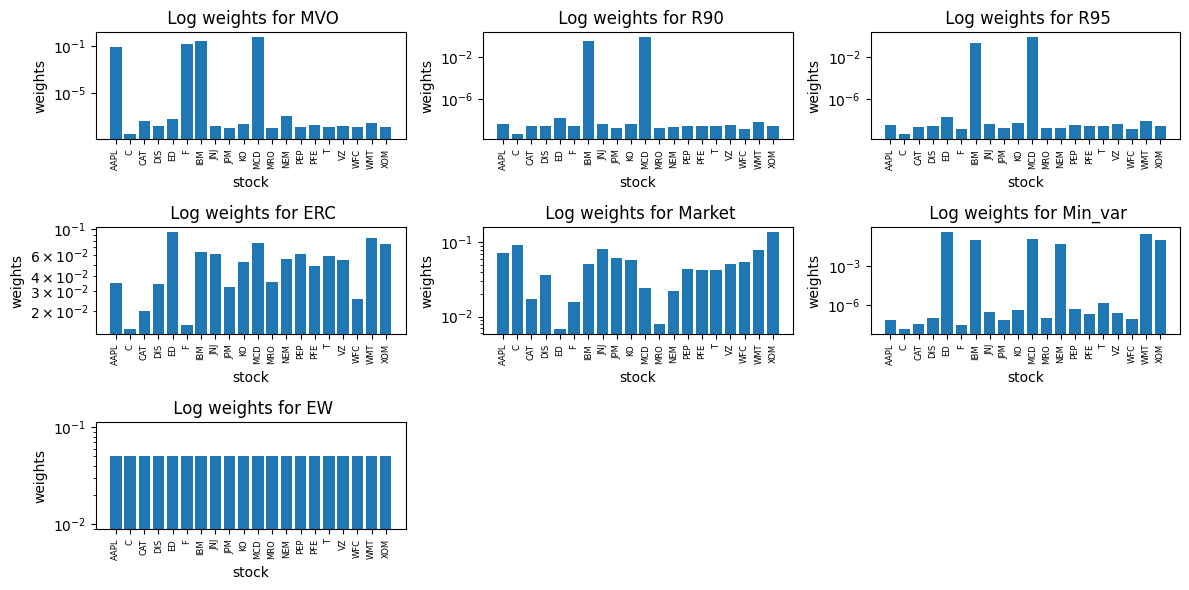

In [ ]:


stock_names = adj_returns.columns

num_rows = 3
num_cols = 3
fig,axes = plt.subplots(num_rows, num_cols, figsize = (12,6))

for i in range(num_rows*num_cols):
  if i < len(weights_list):
    ax = axes.flatten()[i]
    x = np.arange(len(stock_names))
    ax.bar(x, weights_list[i])
    ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xticklabels(stock_names, rotation ='vertical', fontsize =6)
    ax.set_xlabel("stock")
    ax.set_ylabel("weights")
    ax.set_title(f' Log weights for {result_indices[i]}')
  else:
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [ ]:
part_A_df

,True_Returns,Variance,Std_Dev,Sharpe_Ratio
MVO,0.024303,0.003645,0.060373,0.340604
R90,0.035562,0.001585,0.039807,0.799421
R95,0.033536,0.001630,0.040375,0.737985
ERC,-0.010619,0.002015,0.044889,-0.319869
Market,-0.011069,0.003745,0.061195,-0.241998
Min_var,0.002121,0.001009,0.031770,-0.050971
EW,-0.016003,0.003755,0.061276,-0.322203


## Part B (Rolling Estimation Horizons)

In [ ]:
# Start rolling January 2011 to June 2011 Data -> adj_close: 37-42
# means use returns from February 2011 to June 2011 -> adj_return: 37-41
# Test rolling on July 2011 -> adj_return 42
# End testing with December 2011 - requires additional datapoint (47), only have up to 46 atm
# Move period one month

monthly_results=[]
weight_sets = []

part_B_returns_list = []
part_B_variances_list = []
part_B_std_list = []
part_B_sharpe_list = []

result_columns =  ["True_Returns", "Variance", "Std_Dev","Sharpe_Ratio"]
result_indices = ["MVO", "R90", "R95", "ERC", "Market", "Min_var", "EW"]

for i in range(5):

  adjusted_close_portion = adj_close.iloc[(i+37):(i+43),:] #Take indices till 42 (June 2011)
  adjusted_returns_portion = adj_returns.iloc[(i+37):(i+42),:] #Take indices till 41 (June 2011)

  market_weights_portion = market_weights.iloc[(i+37):(i+43),:]

  # Relevant Covariance Matrix
  part_b_Q = adjusted_returns_portion.cov().values

  # Relevant next month returns
  next_true_returns = adj_returns.iloc[(i+42),:]

  # Compute Weights
  weights_list_B = compute_weights(adjusted_close_portion, adjusted_returns_portion, market_weights_portion, risk_lambda)

  weight_sets.append(weights_list_B)


  results_list = []

  for weights in weights_list_B:
    results_list.append( compute_parameters(weights, part_b_Q, next_true_returns, risk_free_rate ))

  # Look at results showing all data for each month
  df = pd.DataFrame(results_list, columns = result_columns, index =  result_indices)
  monthly_results.append(df)

  # Look at a particular result data over all months
  part_B_returns = []
  part_B_variances = []
  part_B_std = []
  part_B_sharpe = []

  for index in range(len(results_list)):
    # Record all returns for each MVO
    part_B_returns.append(results_list[index][0])

    # Record all variances for each MVO
    part_B_variances.append(results_list[index][1])
    part_B_std.append(results_list[index][2])

    # Record all Sharpe Ratios for each MVO
    part_B_sharpe.append(results_list[index][3])

  # Append the lists for each type - will become part of new dataframe
  # for each type of data
  part_B_returns_list.append(part_B_returns)
  part_B_variances_list.append(part_B_variances)
  part_B_std_list.append(part_B_std)
  part_B_sharpe_list.append(part_B_sharpe)


<ipython-input-64-1699f97279d1>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.square(x[i] * (Q@x)[i] - theta) for i in range(n_assets))
<ipython-input-64-1699f97279d1>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.square(x[i] * (Q@x)[i] - theta) for i in range(n_assets))
<ipython-input-64-1699f97279d1>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.square(x[i] * (Q@x)[i] - theta) for i in range(n_assets))
<ipython-input-64-1699f97279d1>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give

In [ ]:
part_B_returns_df = pd.DataFrame(part_B_returns_list, columns = result_indices)
part_B_variances_df = pd.DataFrame(part_B_variances_list, columns = result_indices)
part_B_std_df = pd.DataFrame(part_B_std_list, columns = result_indices)
part_B_sharpe_df = pd.DataFrame(part_B_sharpe_list, columns = result_indices)

In [ ]:
part_B_returns_df

,MVO,R90,R95,ERC,Market,Min_var,EW
0,0.003595,0.025617,0.025617,-0.014704,-0.002623,-0.005885,-0.016003
1,0.052516,0.052516,0.052516,-0.021348,-0.028421,-0.029071,-0.026046
2,-0.028647,-0.028647,-0.028647,-0.048816,-0.049062,-0.046833,-0.063767
3,0.057277,0.057277,0.057277,0.076460,0.079679,0.055488,0.097190
4,-0.034641,0.014141,0.014141,-0.020172,-0.037465,-0.005641,-0.038519


In [ ]:
part_B_variances_df

,MVO,R90,R95,ERC,Market,Min_var,EW
0,0.000118,0.000253,0.000253,0.000303,0.000495,1.848791e-14,0.000443
1,0.000248,0.000248,0.000248,0.000249,0.000362,5.437500e-14,0.000426
2,0.000145,0.000145,0.000145,0.000255,0.000494,1.262313e-14,0.000467
3,0.001071,0.001071,0.001071,0.000195,0.000307,2.996861e-15,0.000449
4,0.002900,0.001177,0.001177,0.000642,0.002300,7.166227e-05,0.003649


In [ ]:
part_B_sharpe_df

,MVO,R90,R95,ERC,Market,Min_var,EW
0,-0.013316,1.374618,1.374618,-1.058934,-0.285956,-70790.001016,-0.938341
1,3.095171,3.095171,3.095171,-1.589373,-1.690226,-140709.297348,-1.443568
2,-2.693460,-2.693460,-2.693460,-3.292186,-2.376708,-450126.873014,-3.124104
3,1.636054,1.636054,1.636054,5.211729,4.335952,945271.604964,4.410019
4,-0.712760,0.303107,0.303107,-0.943489,-0.859186,-1.108188,-0.699546


## Part C (Plots)

In [ ]:
# List of columns we want to display results for at the moment
columns_to_use = ["MVO", "R90", "R95", "ERC", "Market"]
#columns_to_use = ["MVO", "R90", "R95", "ERC", "Market", "EW"]
#columns_to_use = ["MVO", "R90", "R95", "ERC", "Market", "Min_Var", "EW"]

# Convert Part B Returns dataframe to cumulative product to catch all returns

cum_ret = (part_B_returns_df + 1).cumprod()



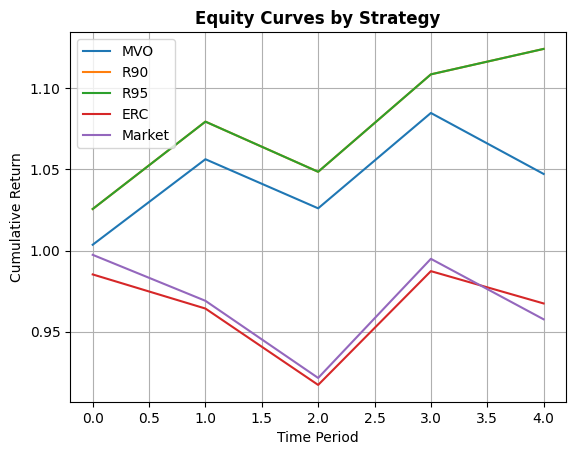

In [ ]:
for column in columns_to_use:
  plt.plot(cum_ret.index, cum_ret.loc[:,column], label = str(column))

plt.legend()
plt.title("Equity Curves by Strategy", weight = 'bold')
plt.xlabel("Time Period")
plt.ylabel("Cumulative Return")
plt.grid(True)

plt.show()

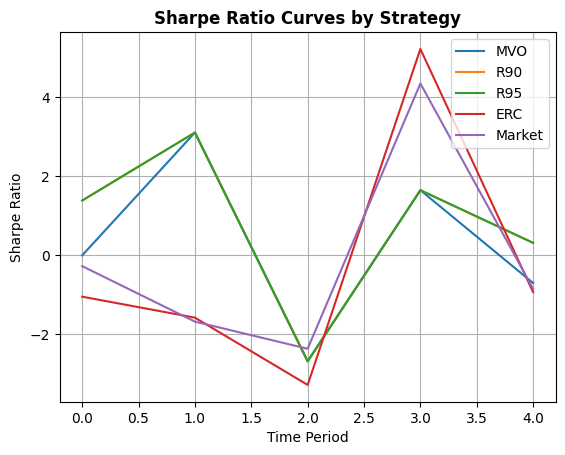

In [ ]:
for column in columns_to_use:
  plt.plot(part_B_sharpe_df.index, part_B_sharpe_df.loc[:,column], label = str(column))


plt.title("Sharpe Ratio Curves by Strategy", weight = 'bold')
plt.xlabel("Time Period")
plt.ylabel("Sharpe Ratio")
plt.legend(loc = 1)
plt.grid(True)

plt.show()